## Getting Started

- Download MapPLUTO data from [NYC DCP](https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v1_1_shp.zip)
- Unzip the file and place contents in the `Data` directory at the root of this repo
- Make sure you have installed all requisite libraries by running `pip install -r requirements.txt` **_with your virtual environment activated_**

## Goals

- Load data from file
- Explore spatial and non-spatial elements of the dataset
- Compare tradeoffs between different methods of loading data
- Demonstrate tradeoffs in different file formats


In [2]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

# load PLUTO data


In [2]:
# pluto = gpd.read_file("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

In [3]:
pluto_ogrio = ogr.read_dataframe("C:/Users/jiang/Documents/GitHub/cdp-mapping-systems/Data/MapPLUTO.shp")

# basic exploration


In [3]:
pluto_ogrio.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [4]:
pluto_ogrio.dtypes

Borough         object
Block            int64
Lot              int32
CD               int32
BCT2020         object
                ...   
Longitude      float64
Notes           object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
Length: 95, dtype: object

## categorical column


In [14]:
pluto_ogrio.OwnerType.value_counts()

OwnerType
X    18947
C    13010
O     1418
P      586
M       84
Name: count, dtype: int64

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [16]:
# now we can remap the numbers into something more meaningful

OwnerType_codes = {
    "X": "Partnership",
    "C": "Corporation",
    "O": "Other",
    "P": "Private organization",
    "M": "Municipal",
}

In [17]:
pluto_ogrio["OwnerType"] = pluto_ogrio.OwnerType.map(OwnerType_codes)

In [18]:
pluto_ogrio.groupby("OwnerType").OwnerType.sum()

OwnerType
Corporation             CorporationCorporationCorporationCorporationCo...
Municipal               MunicipalMunicipalMunicipalMunicipalMunicipalM...
Other                   OtherOtherOtherOtherOtherOtherOtherOtherOtherO...
Partnership             PartnershipPartnershipPartnershipPartnershipPa...
Private organization    Private organizationPrivate organizationPrivat...
Name: OwnerType, dtype: object

<Axes: xlabel='OwnerType'>

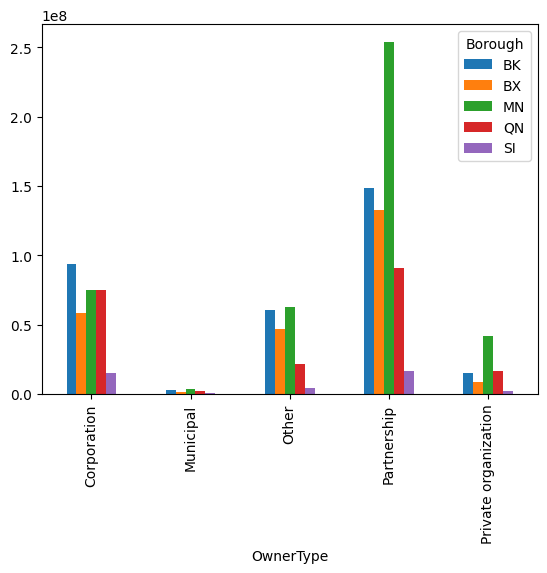

In [25]:
pluto_ogrio.groupby(["OwnerType", "Borough"]).BldgArea.sum().unstack().plot.bar()


Building Area and Building Age 

Text(0.5, 1.0, 'Onwer Type by Building Area')

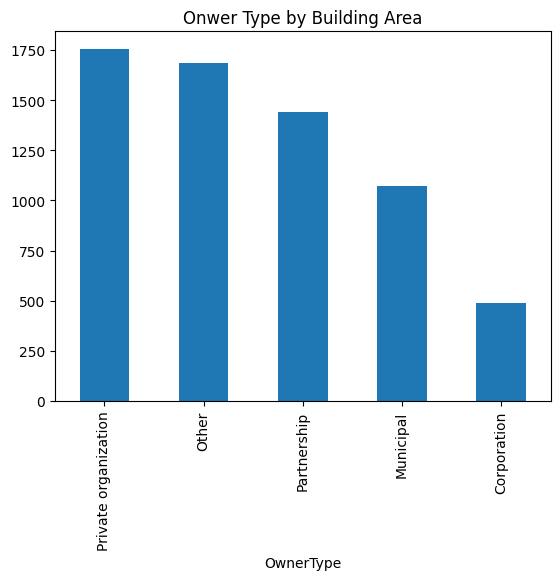

In [96]:
pluto_ogrio.groupby("OwnerType")["YearBuilt"].mean().sort_values(ascending=False).plot.bar()
plt.title("Onwer Type by Building Area")

## numeric column


In [31]:
pluto_ogrio["YearBuilt"].describe()

count    856819.000000
mean       1851.210777
std         409.596987
min           0.000000
25%        1920.000000
50%        1930.000000
75%        1960.000000
max        2023.000000
Name: YearBuilt, dtype: float64

Text(0.5, 1.0, 'Number of Buildings for Each Built Year')

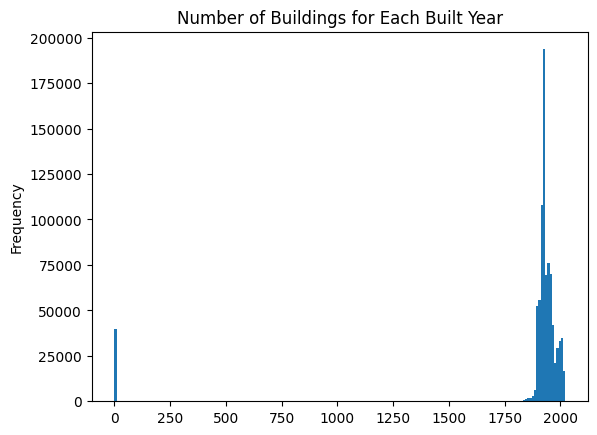

In [104]:
pluto_ogrio["YearBuilt"].plot.hist(bins=200)
plt.title("Number of Buildings for Each Built Year")

<Axes: xlabel='YearBuilt'>

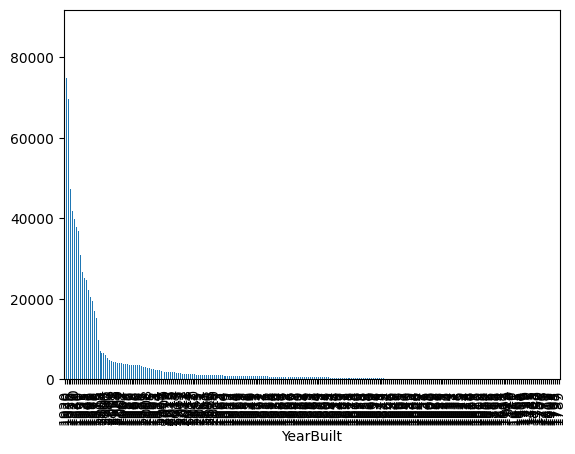

In [110]:
pluto_ogrio.groupby("YearBuilt").size().sort_values(ascending=False).plot.bar()

## Your turn:

- Histogram for each borough
- then, choose another chart type to visualize the distribution of lot area for each borough. See [here](https://matplotlib.org/stable/plot_types/index.html) for some built in options in matplotlib, or here for [seaborn](https://seaborn.pydata.org/tutorial/distributions.html)


Text(0.5, 1.0, 'Building Age by Borough')

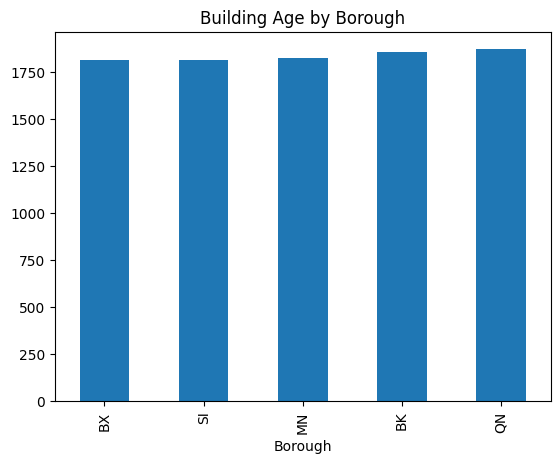

In [103]:
pluto_ogrio.groupby("Borough")["YearBuilt"].mean().sort_values(ascending=True).plot.bar()
plt.title("Building Age by Borough")

## Ok, now let's make a boxplot to see how wide the range is within each boro's data


<Axes: title={'center': 'YearBuilt'}, xlabel='Borough'>

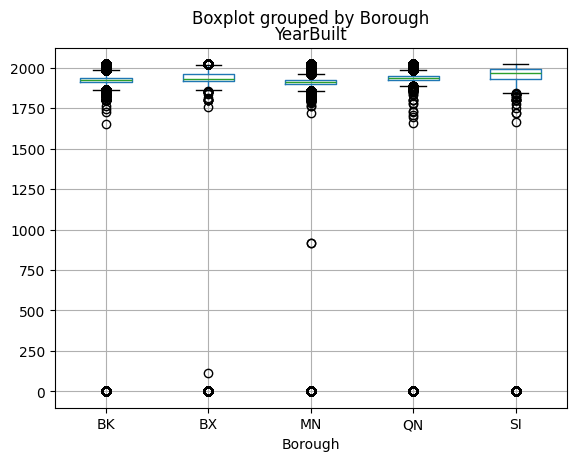

In [87]:
pluto_ogrio.boxplot(column="YearBuilt", by="Borough")

What does this distribution tell us about the number of floors in each borough?


# cluster by number of floors


In [72]:
# get clusters using kmeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["BldgArea", "YearBuilt"]])

pluto_ogrio["NewCluster"] = kmeans.predict(pluto_ogrio[["BldgArea", "YearBuilt"]])

In [73]:
pluto_ogrio.groupby("NewCluster").NumFloors.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NewCluster,,,,,,,,
1,5.0,9.200000,13.754999,0.0,1.00,3.0,9.0,33.0
0,851465.0,2.271706,1.350478,0.0,2.00,2.0,2.5,57.0
3,4867.0,14.970310,11.807162,0.0,6.00,13.0,20.0,90.0
2,466.0,26.898069,18.789434,0.0,12.00,23.0,41.0,102.0
4,16.0,17.375000,25.523519,0.0,3.25,10.5,19.0,104.0


<Axes: xlabel='BldgArea', ylabel='YearBuilt'>

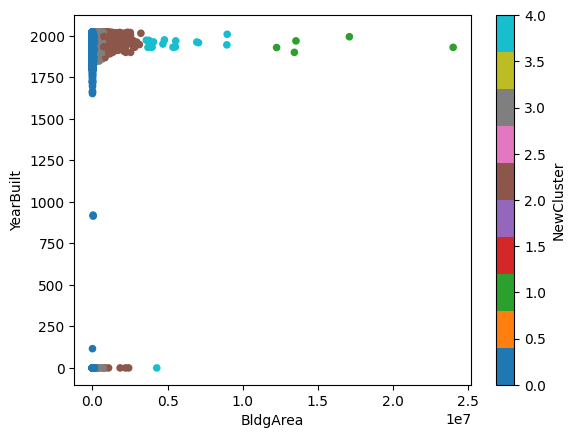

In [74]:
pluto_ogrio.plot.scatter(x="BldgArea", y="YearBuilt", c="NewCluster", cmap="tab10")

<Axes: xlabel='YearBuilt', ylabel='BldgArea'>

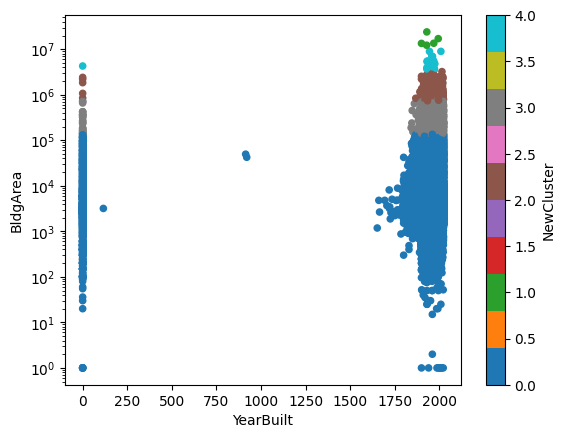

In [75]:
# same as above but with log y axis
pluto_ogrio.plot.scatter(
    x="YearBuilt", y="BldgArea", c="NewCluster", cmap="tab10", logy=True
)

<Axes: ylabel='Frequency'>

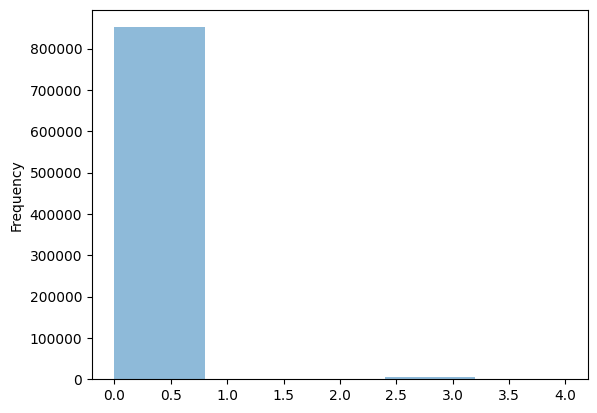

In [76]:
pluto_ogrio["NewCluster"].plot.hist(bins=5, alpha=0.5)

# and now, mapping


## static map


Text(0.5, 1.0, 'NYC MapPLUTO')

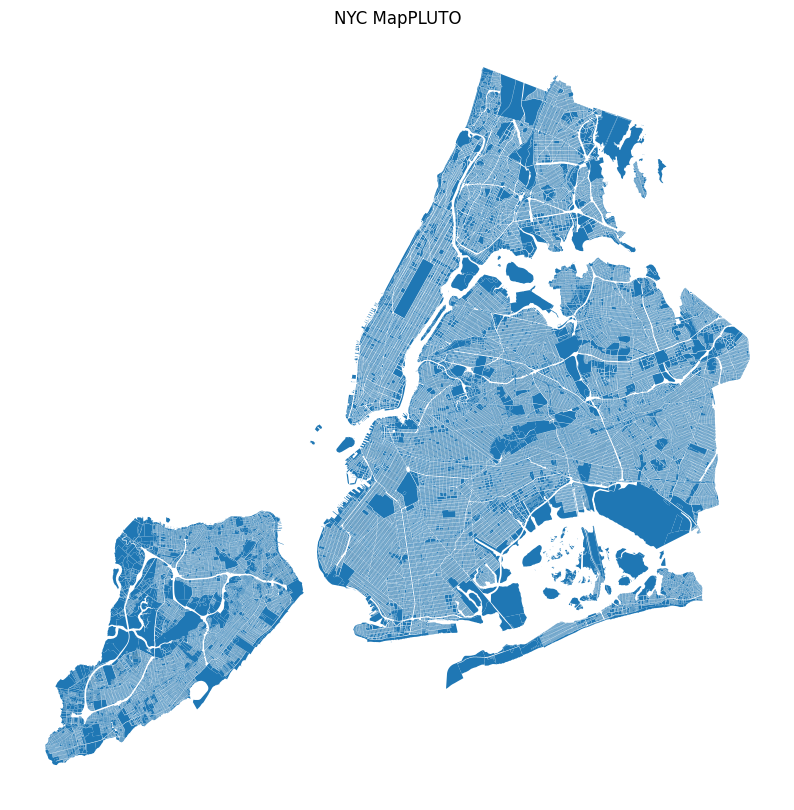

In [77]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapPLUTO")

In [84]:
cmap = {
    "Partnership": "#ff0000",
    "Corporation": "#00ff00",
    "Other": "#0000ff",
    "Private organization": "#ff00ff",
    "Municipal": "#ffff00",
}

In [85]:
pluto_ogrio["color"] = pluto_ogrio["OwnerType"].map(cmap)

C:\Users\jiang\AppData\Local\Temp\ipykernel_39520\4096294850.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pluto_ogrio["color"].fillna("gray", inplace=True)


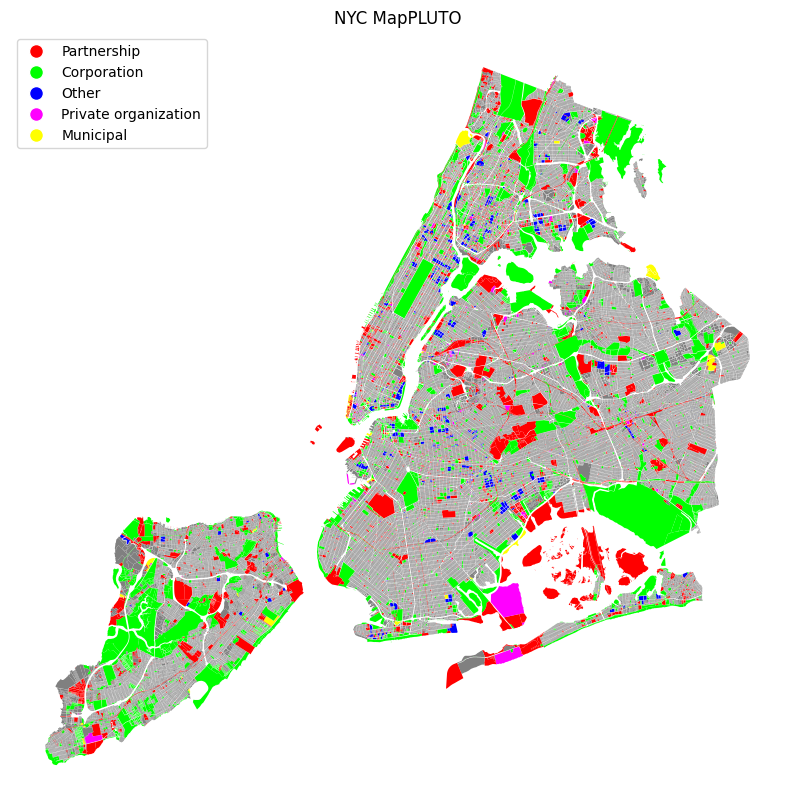

In [86]:
pluto_ogrio["color"].fillna("gray", inplace=True)

ax = pluto_ogrio.plot(
    color=pluto_ogrio["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapPLUTO")


# populate legend items based on dict from above
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

Text(0.5, 1.0, 'NYC OwnerType')

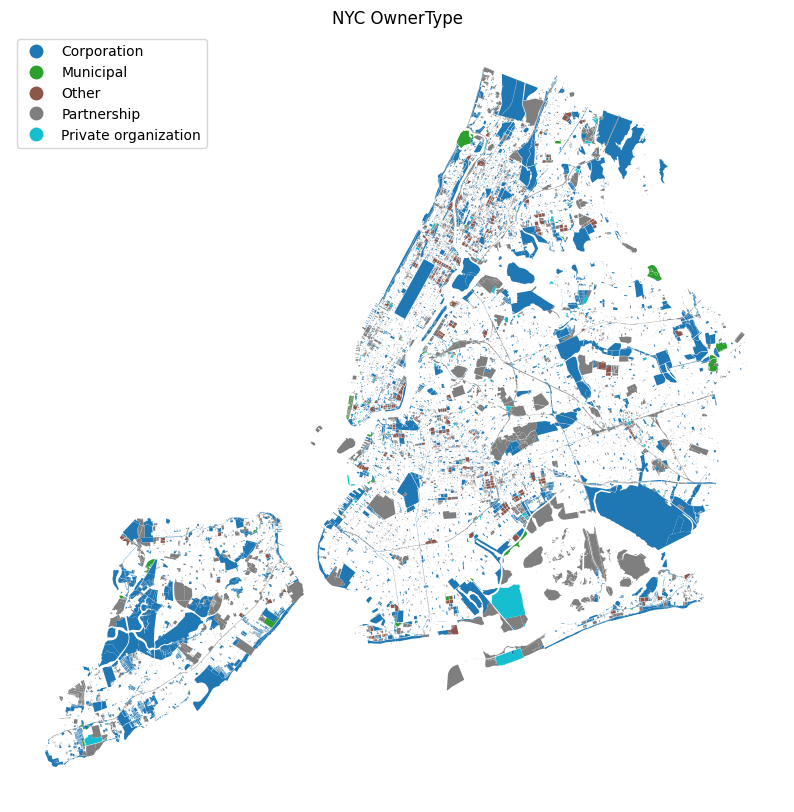

In [88]:
pluto_ogrio.plot(
    column="OwnerType", figsize=(10, 10), legend=True, legend_kwds={"loc": "upper left"}
).set_axis_off()
plt.title("NYC OwnerType")

## Your turn:

- map a numeric column using a continuous colormap for Queens. See here for a list and discussion of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- What patterns emerge?


# prep for interactive mapping


In [29]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

## visualize a categorical variable


In [30]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

NameError: name 'cmap' is not defined

In [93]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [94]:
len(pluto_ogrio_wgs[pluto_ogrio_wgs["LandUse"].isna()])

2649

In [95]:
pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_47985/961482650.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)


## uhoh- observe the above warning- re-write the code to avoid this


## now, we can plot the data using lonboard to create an interactive map


In [96]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x1cd1059c0>
[
  [
    128,
…

In [35]:
pluto_ogrio_wgs["LandUse"] = pluto_ogrio_wgs["LandUse"].astype("category")

In [36]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x165160280>
[
  [
    128,
…

In [55]:
pluto_ogrio_wgs[pluto_ogrio_wgs.geometry.isna()]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,NumFloorsCluster,color


## visualize a continuous variable


In [101]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x1ceca89a0>
[
  42,
 …

## your turn: can you make the above show in 3d?

- see here for some tips: https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports


# save data


In [ ]:
# save out as fgb using geopandas
# pluto_ogrio.to_file("..Data/nyc_mappluto_24v1_1_shp/mappluto.fgb")

In [ ]:
# ogr.write_dataframe(pluto_ogrio, "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb")